In [2]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Brendan TM\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os 
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import splitfolders

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

In [3]:
train_base_path = "../asl_alphabet_train/asl_alphabet_train"  # Correct the base path

categories = {
    0: "a",
    1: "b",
    2: "c",
    3: "d",
    4: "e",
    5: "f",
    6: "g",
    7: "h",
    8: "i",
    9: "j",
    10: "k",
    11: "l",
    12: "m",
    13: "n",
    14: "o",
    15: "p",
    16: "q",
    17: "r",
    18: "s",
    19: "t",
    20: "u",
    21: "v",
    22: "w",
    23: "x",
    24: "y",
    25: "z",
    26: "del",
    27: "nothing",
    28: "space",
}

filenames_list = []
categories_list = []

for category in categories.values():
    folder_path = os.path.join(train_base_path, category.upper())  
    folder_path = folder_path.replace("\\", "/")  

    # Check if the folder exists
    if os.path.exists(folder_path):
        filenames = os.listdir(folder_path)
        for filename in filenames:
        
            full_path = os.path.join(folder_path, filename).replace("\\", "/")  
            filenames_list.append(full_path)
            categories_list.append(category)
    else:
        print(f"Warning: Folder '{folder_path}' does not exist.")

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})



In [4]:
df

filename category
0      ../asl_alphabet_train/asl_alphabet_train/A/A1.jpg        a
1      ../asl_alphabet_train/asl_alphabet_train/A/A10...        a
2      ../asl_alphabet_train/asl_alphabet_train/A/A10...        a
3      ../asl_alphabet_train/asl_alphabet_train/A/A10...        a
4      ../asl_alphabet_train/asl_alphabet_train/A/A10...        a
...                                                  ...      ...
86995  ../asl_alphabet_train/asl_alphabet_train/SPACE...    space
86996  ../asl_alphabet_train/asl_alphabet_train/SPACE...    space
86997  ../asl_alphabet_train/asl_alphabet_train/SPACE...    space
86998  ../asl_alphabet_train/asl_alphabet_train/SPACE...    space
86999  ../asl_alphabet_train/asl_alphabet_train/SPACE...    space

[87000 rows x 2 columns]

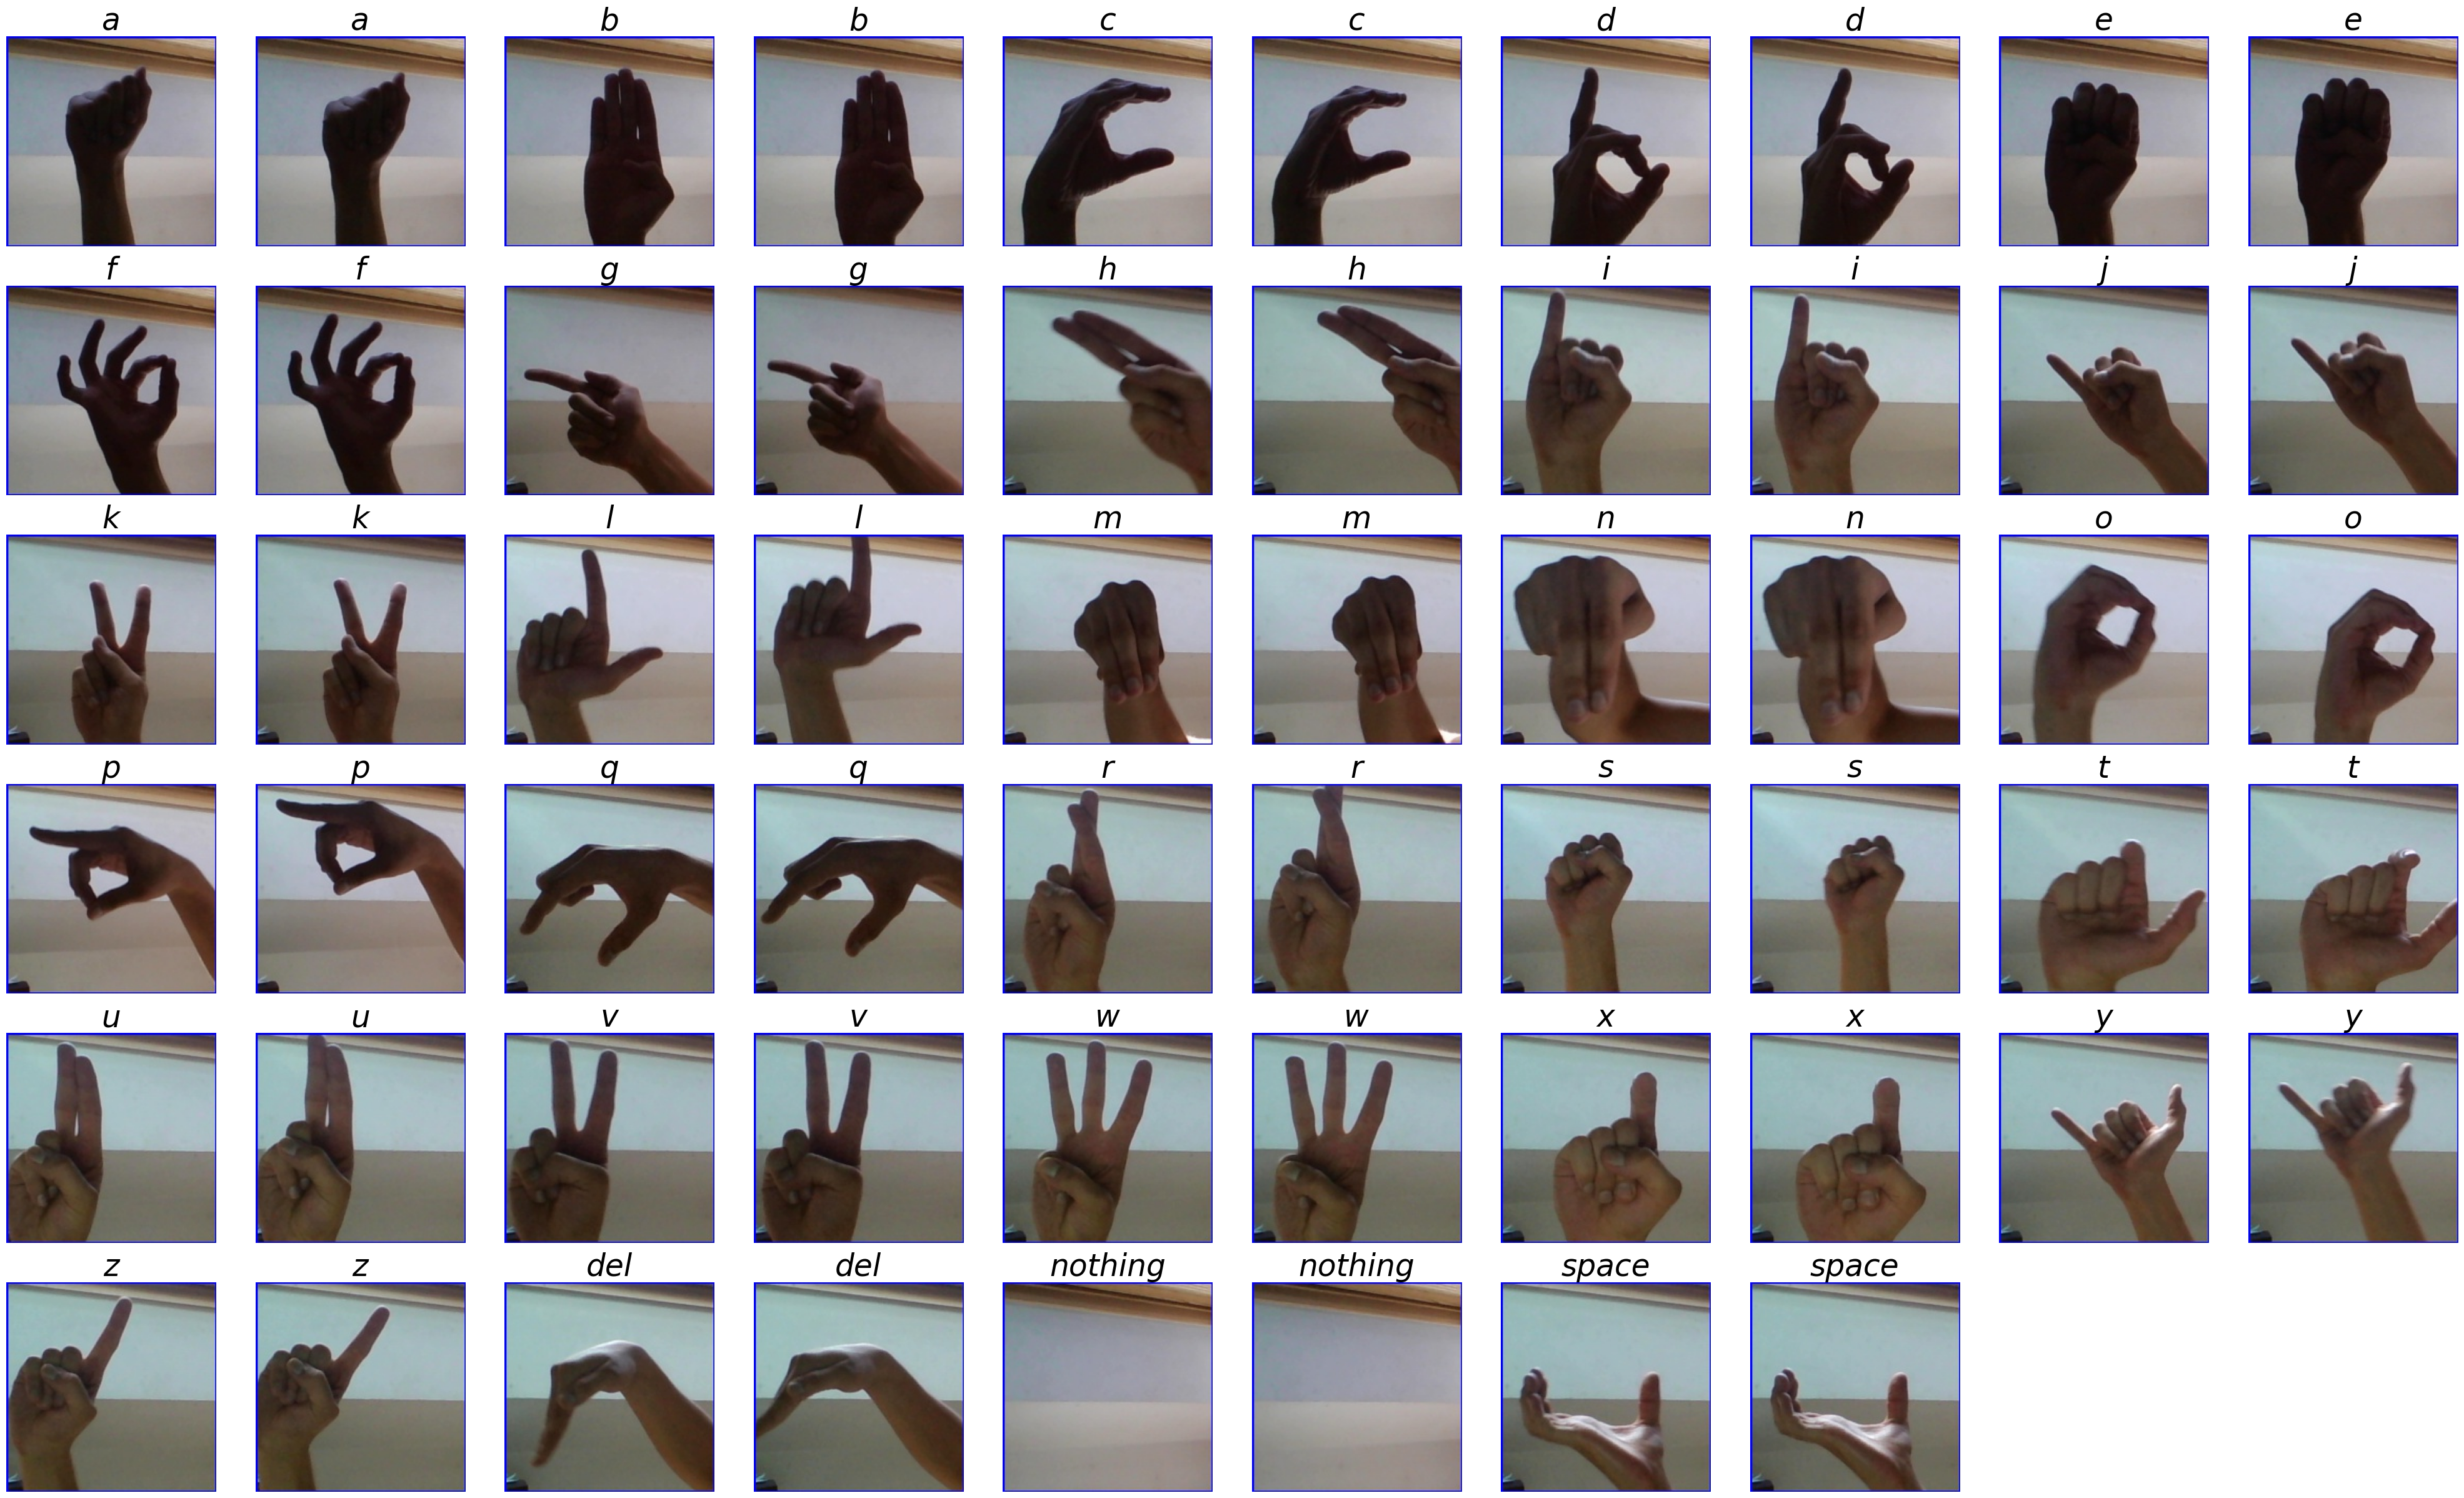

In [5]:
train_base_path = "../asl_alphabet_train/asl_alphabet_train"  

category_counts = {category: 0 for category in categories.values()}

plt.figure(figsize=(40, 40))

count = 0
for i in range(len(df)): 
    category = df.category[i]
    
    if category_counts[category] >= 2:
        continue
    
    category_counts[category] += 1
    
    path = os.path.join(df.filename[i])
    
    img = plt.imread(path)
    plt.subplot(10, 10, count + 1)  
    plt.imshow(img)
    
    category_title = df.category[i] 
    plt.title(category_title, fontsize=35, fontstyle='italic')
    
    plt.axis("off")
    
    count += 1
    
    if count >= 100:
        break

plt.tight_layout()
plt.show()

C:\Users\Brendan TM\AppData\Local\Temp\ipykernel_22588\842432032.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)


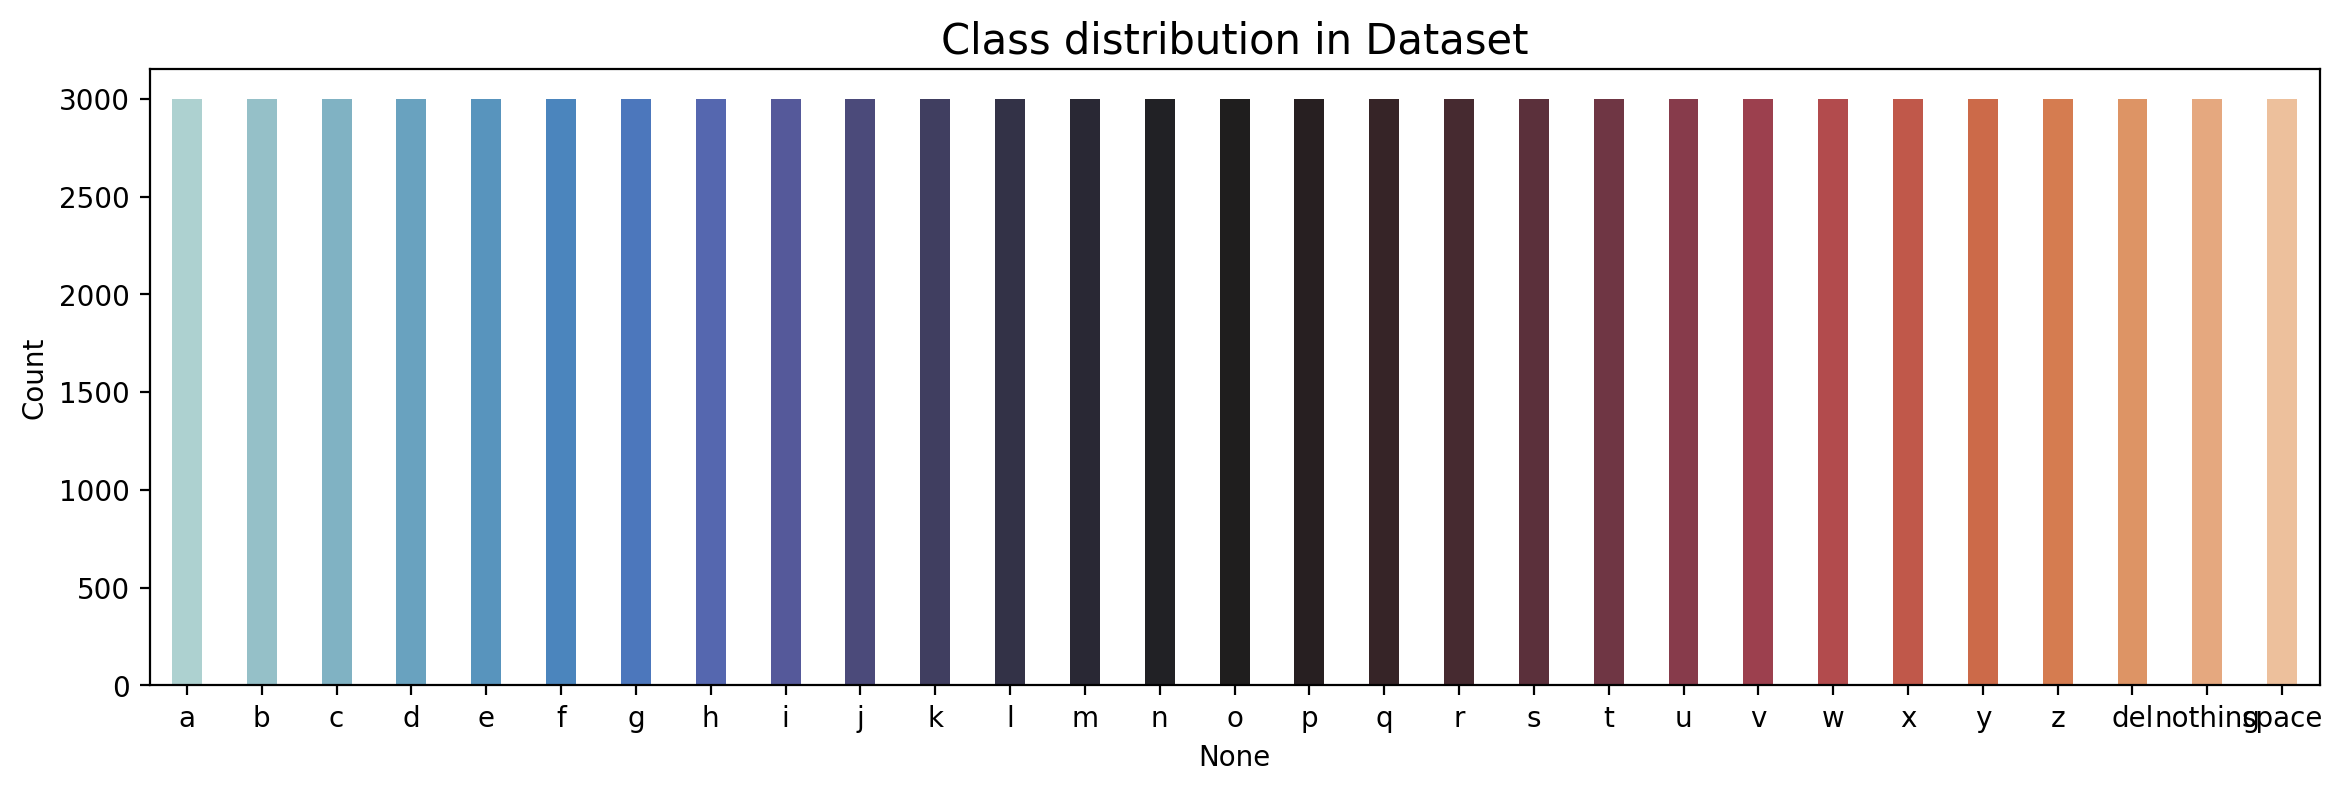

In [44]:
label,count = np.unique(df.category,return_counts=True)
uni = pd.DataFrame(data=count,index=categories.values(),columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)
plt.show()

In [ ]:
# Split the dataset into training and validation sets
splitfolders.ratio('../asl_alphabet_train/asl_alphabet_train', output='asl_dataset', seed=1333, ratio=(0.8, 0.2))


Copying files: 87000 files [00:52, 1659.70 files/s]


In [ ]:
# Split the dataset into training and validation sets
splitfolders.ratio('../asl_alphabet_train/asl_alphabet_train', output='asl_dataset_tmp', seed=1333, ratio=(0.2, 0.1, 0.7))

Copying files: 87000 files [07:49, 185.45 files/s]


In [18]:
datagen = ImageDataGenerator(rescale= 1.0 / 255)

In [ ]:
train_path = '../asl_dataset_tmp/train/'
val_path = '../asl_dataset_tmp/val/'
test_path = '../asl_dataset/val/'

batch = 32
image_size = 200
img_channel = 3
n_classes = 29

In [20]:
train_data = datagen.flow_from_directory(directory= train_path, 
                                         target_size=(image_size,image_size), 
                                         batch_size = batch, 
                                         class_mode='categorical')

val_data = datagen.flow_from_directory(directory= val_path, 
                                       target_size=(image_size,image_size), 
                                       batch_size = batch, 
                                       class_mode='categorical',
                                       )

test_data = datagen.flow_from_directory(directory= test_path, 
                                         target_size=(image_size,image_size), 
                                         batch_size = batch, 
                                         class_mode='categorical',
                                         shuffle= False)

Found 17400 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [21]:
# Define the model
model = Sequential()

# Input layer
# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, img_channel)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.4))

# Fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(29, activation='softmax'))

# Summary
model.summary()


C:\Users\Brendan TM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 200, 200, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    40,960,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,387,197 (157.88 MB)

 Trainable params: 41,386,749 (157.88 MB)

 Non-trainable params: 448 (1.75 KB)

In [22]:
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.0005, 
    patience=10, 
    restore_best_weights=True, 
    verbose=1
)

# Reduce Learning Rate on Plateau
reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss', 
    patience=4, 
    factor=0.5, 
    verbose=1
)

In [23]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),  
    loss='categorical_crossentropy',    
    metrics=['accuracy']                
)


In [ ]:
asl_class = model.fit(train_data, 
                      validation_data= val_data, 
                      epochs=30, 
                      batch_size=64,
                      callbacks=[early_stopping,reduce_learning_rate],
                      verbose = 1)

In [18]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_data , verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_data, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 98.36207032203674
The Loss of the model for training data is: 0.04890168458223343
The accuracy of the model for validation data is: 96.21838927268982
The Loss of the model for validation data is: 0.12250170856714249


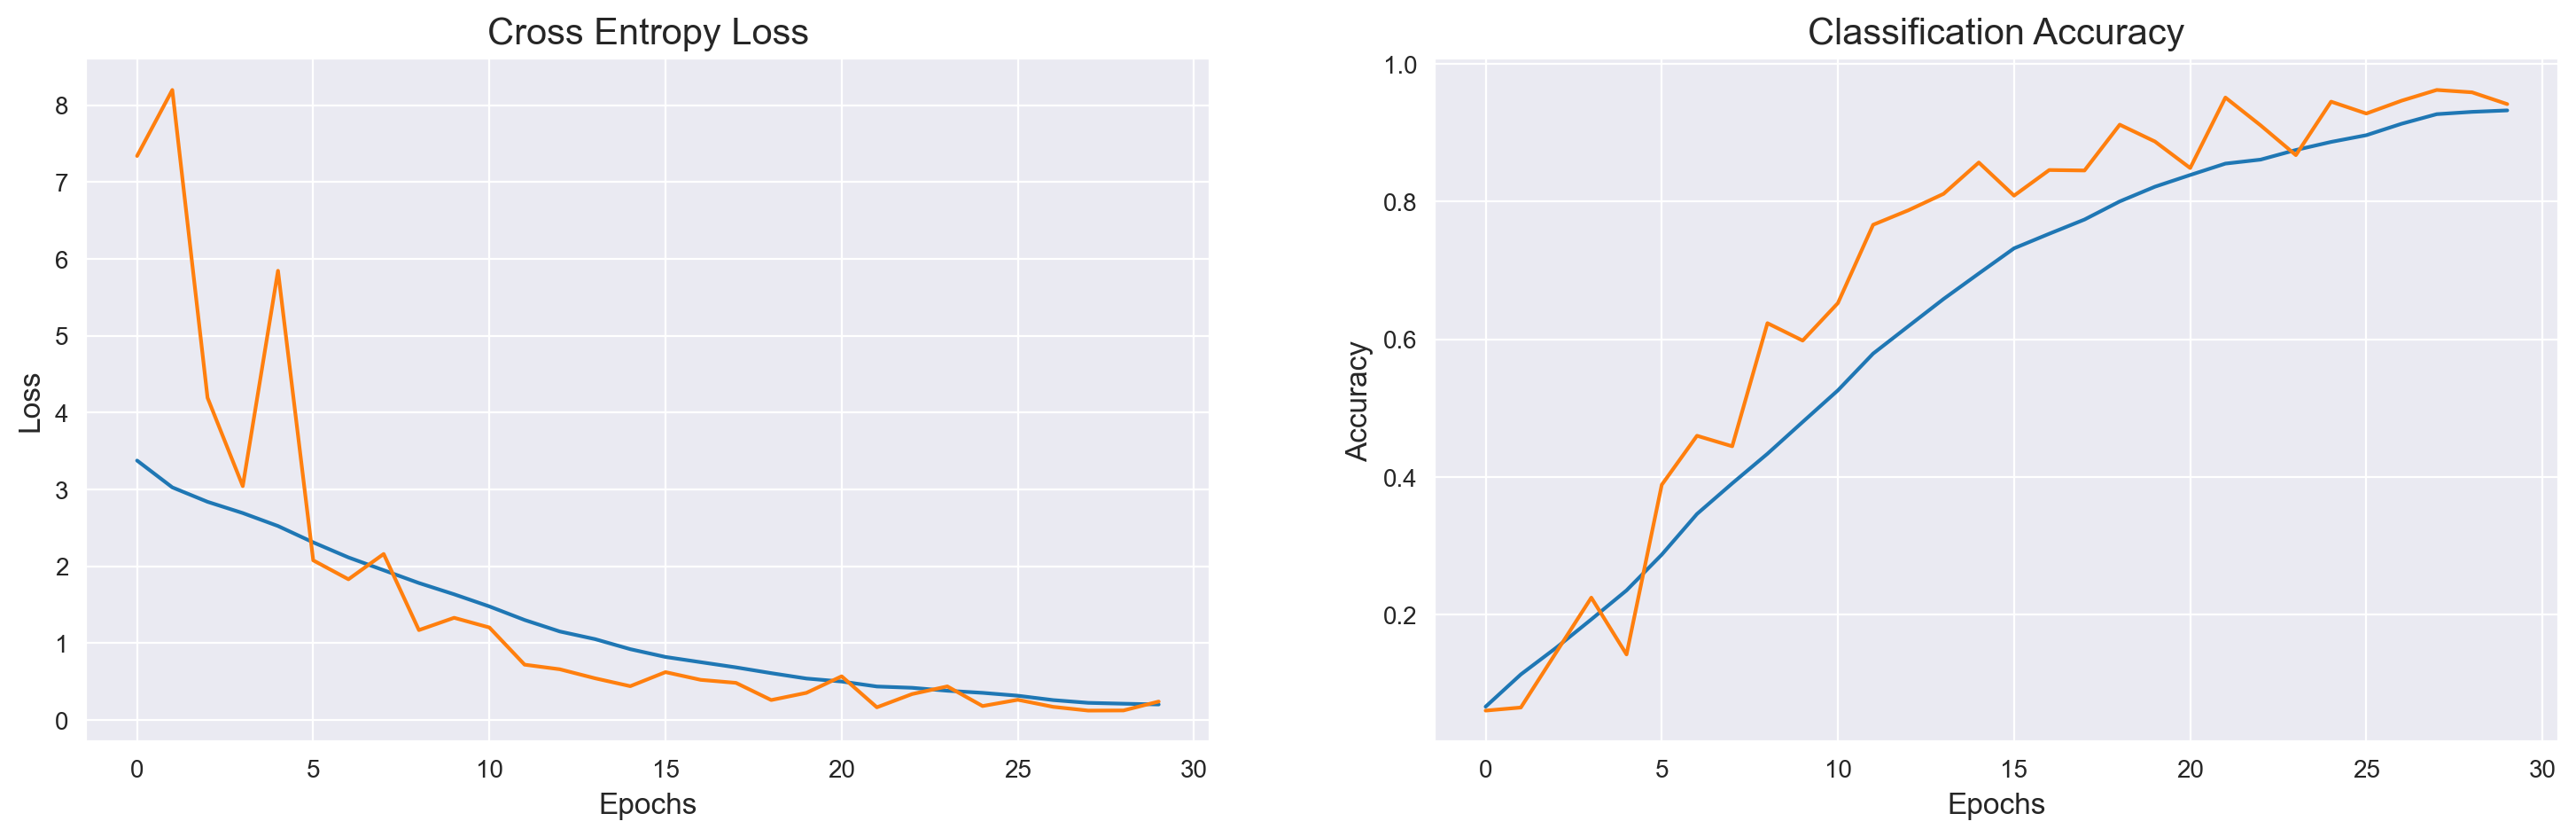

In [19]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(asl_class.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [9]:
# prediction
result = model.predict(test_data,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_data.labels

# Evaluvate
loss,acc = model.evaluate(test_data,verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

NameError: name 'model' is not defined

In [25]:
p = y_pred
y = y_true
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 16679
Incorrect predicted classes: 721


In [28]:
print(classification_report(y_true, y_pred,target_names= categories.values()))

              precision    recall  f1-score   support

           a       0.98      0.95      0.96       600
           b       0.95      0.99      0.97       600
           c       0.99      0.99      0.99       600
           d       0.98      1.00      0.99       600
           e       0.99      0.93      0.96       600
           f       1.00      1.00      1.00       600
           g       0.98      0.94      0.96       600
           h       0.95      0.97      0.96       600
           i       1.00      0.97      0.99       600
           j       1.00      1.00      1.00       600
           k       0.96      1.00      0.98       600
           l       0.99      0.99      0.99       600
           m       0.97      0.88      0.92       600
           n       0.90      0.98      0.94       600
           o       0.93      0.94      0.93       600
           p       0.98      0.99      0.99       600
           q       0.98      0.99      0.99       600
           r       0.96    

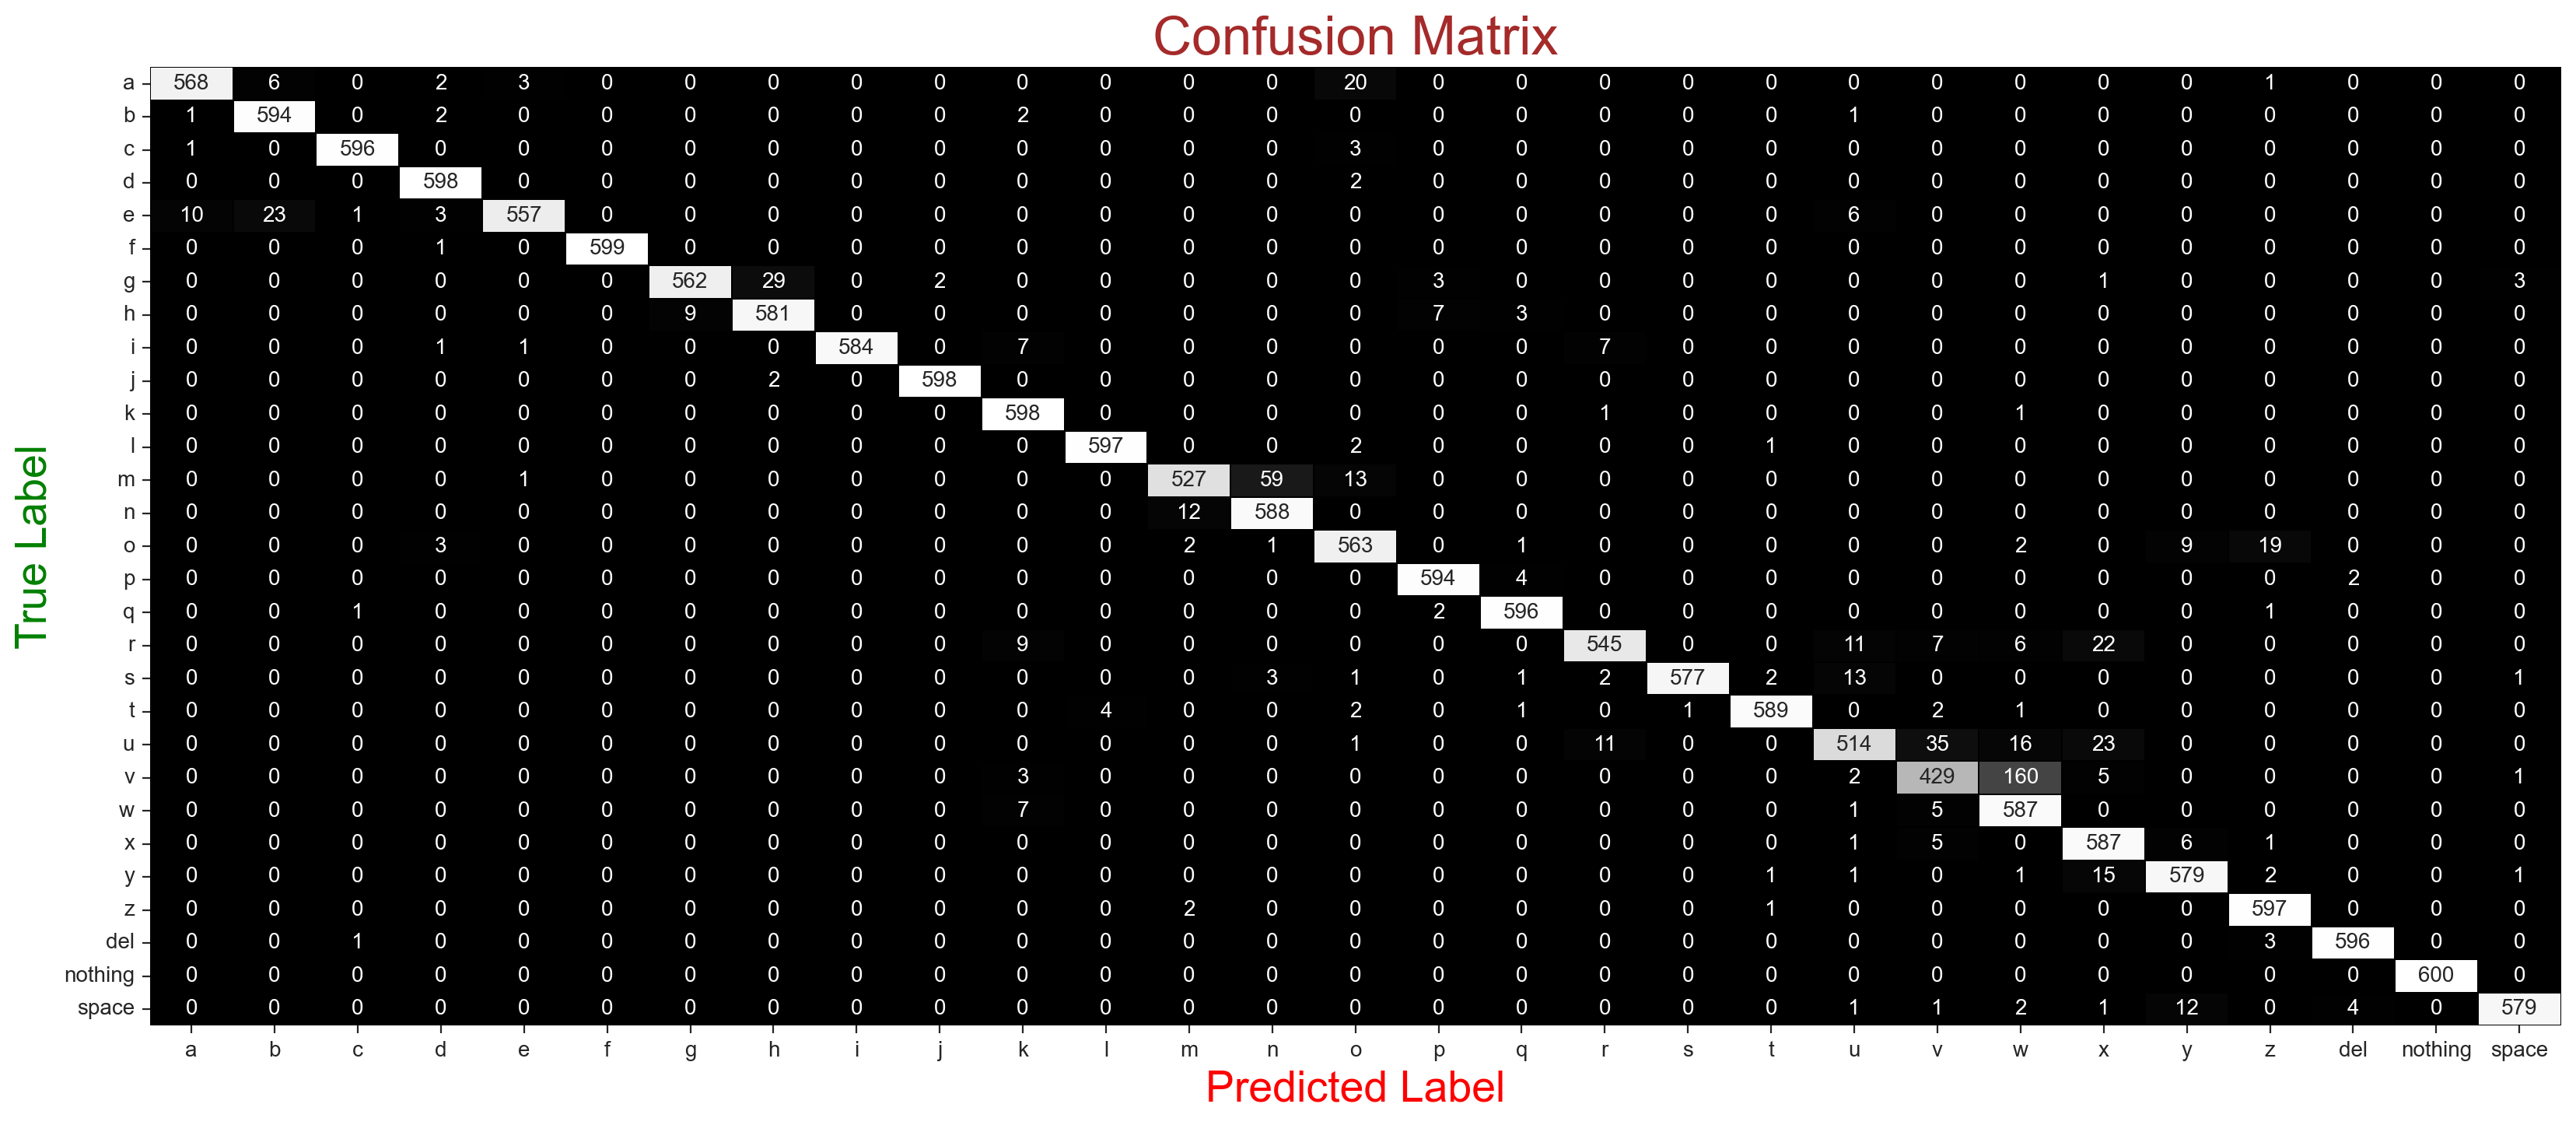

In [29]:
sns.set_style('ticks')

confusion_mtx = confusion_matrix(y_true,y_pred) 

f,ax = plt.subplots(figsize = (20,8),dpi=200)

sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.1, cmap = "gist_yarg_r", 
            linecolor="black", fmt='.0f', ax=ax, 
            cbar=False, xticklabels=categories.values(), 
            yticklabels=categories.values())

plt.xlabel("Predicted Label",fontdict={'color':'red','size':20})
plt.ylabel("True Label",fontdict={'color':'green','size':20})
plt.title("Confusion Matrix",fontdict={'color':'brown','size':25})

plt.show()

In [ ]:
model.save('my_model.h5')  
model.save('my_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('my_model.h5')

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Brendan TM\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [32]:
import cv2
import numpy as np

def preprocess_video(video_path, image_size):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize frame to match the model's input size
        frame = cv2.resize(frame, (image_size, image_size))
        
        # Normalize the pixel values to [0, 1]
        frame = frame.astype('float32') / 255.0
        
        # Append processed frame
        frames.append(frame)
    
    cap.release()
    frames = np.array(frames)
    return frames



In [ ]:
def predict_asl(frames, model):
    predictions = model.predict(frames)  # Predict on all frames
    return predictions


In [5]:
def aggregate_predictions(predictions):
    # Averaging predictions across frames
    mean_predictions = np.mean(predictions, axis=0)
    predicted_class = np.argmax(mean_predictions)  # Get class with highest probability
    return predicted_class


In [ ]:
# Define parameters
video_path = '../signer-10-alphabet-m.mp4'
image_size = 200  # Same as your model's input size

# Step 1: Preprocess the video
frames = preprocess_video(video_path, image_size=200)

# Step 2: Ensure correct shape
print("Processed frames shape:", frames.shape)

# Add batch dimension if a single frame
if len(frames.shape) == 3:
    frames = np.expand_dims(frames, axis=0)

# Step 3: Predict on frames
predictions = model.predict(frames, batch_size=32)

# Step 4: Aggregate predictions
predicted_class = aggregate_predictions(predictions)

# Output Result
if 0 <= predicted_class < len(categories):
    print(f"The predicted ASL gesture is: {categories[predicted_class]}")
else:
    print(f"Error: Predicted class index {predicted_class} is out of range for categories.")




Processed frames shape: (27, 200, 200, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
The predicted ASL gesture is: m
